In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import albumentations as A
from pathlib import Path
from collections import Counter
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import yaml
import shutil
import glob
import math
from threading import Lock

In [2]:
def load_splits(input_dir, max_workers=None):
    """Load the split files (test.txt, train.txt, val.txt) in parallel and return a combined dictionary."""
    
    def read_split_file(split_file, split_type):
        """Read a split file and return a dictionary with image IDs as keys and the split type as values."""
        split_dict = {}
        
        # Convert split_file to a Path object if it's not already one
        split_file = Path(split_file)
        
        with open(split_file, 'r') as f:
            ids = [line.strip() for line in f]
        
        for id in ids:
            image_path = Path(input_dir) / "images" / f"{id}.jpg"
            annotation_path = Path(input_dir) / "annotations" / f"{id}.json"
            
            # Check if both image and annotation files exist
            if image_path.is_file() and annotation_path.is_file():
                split_dict[id] = split_type
            else:
                print(f"Warning: Missing files for ID {id}")
        
        return split_dict
    
    split_dir = Path(input_dir) / "splits"
    split_files = {
        'train': split_dir / "train.txt",
        'val': split_dir / "val.txt",
        'test': split_dir / "test.txt"
    }

    if max_workers is None:
        max_workers = min(os.cpu_count(), len(split_files))

    # Verify that all split files exist before processing
    for split_type, split_file in split_files.items():
        if not split_file.exists():
            raise FileNotFoundError(f"Expected split file not found: {split_file}")
    
    # Use ThreadPoolExecutor to read the files in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(lambda file_split: read_split_file(file_split[1], file_split[0]), split_files.items()))

    # Combine the results from all threads
    split_dict = {}
    for result in results:
        split_dict.update(result)
    
    return split_dict

In [3]:
def process_single_image(id, input_dir, split_type):
    # Load the annotation file
    with open(f"{input_dir}/annotations/{id}.json", 'r') as f:
        annotation = json.load(f)
        
    processed_data = []
    
    # Process each object in the annotation
    for i, obj in enumerate(annotation['objects']):
        # Get bounding box
        bbox = obj['bbox']
        class_name = obj['label']
        xmin, ymin, xmax, ymax = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])
        
        # Generate new id for the cropped image and its annotation
        new_id = f"{id}_{i}"
        
        # Create a new annotation for the cropped image
        new_annotation_data = {
            "ID": new_id,
            "original_id": id,
            "class": class_name,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
            "split": split_type
        }
        
        processed_data.append(new_annotation_data)
    
    return processed_data

In [4]:
def create_expanded_dataframe(split_dict, input_dir):
    """Process all images and annotations and return an expanded DataFrame."""
    all_data = []
    
    def process_batch(ids):
        batch_data = []
        for id, split_type in ids:
            batch_data.extend(process_single_image(id, input_dir, split_type))
        return batch_data
    
    # Use ThreadPoolExecutor to process images in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        batch_size = 50  # Adjust batch size for optimal performance
        image_ids = list(split_dict.items())
        futures = [executor.submit(process_batch, image_ids[i:i + batch_size]) for i in range(0, len(image_ids), batch_size)]
        
        for future in concurrent.futures.as_completed(futures):
            all_data.extend(future.result())
    
    df = pd.DataFrame(all_data)
    
    return df

In [5]:
def balance_classes(df):
    """Balance classes by cutting down oversampled classes."""
    # Calculate the average number of instances per class
    class_counts = df['class_number'].value_counts()
    average_class_size = class_counts.mean()
    
    # Calculate the target size as 125% of the average class size
    target_size = int(average_class_size * 1.25)
    
    # Cut down classes that are above the target size
    balanced_df_list = []
    for class_number, count in class_counts.items():
        class_df = df[df['class_number'] == class_number]
        if count > target_size:
            # Randomly sample to reduce the class size to the target size
            class_df = class_df.sample(n=target_size, replace=False, random_state=42)
        balanced_df_list.append(class_df)
    
    # Combine the balanced classes back into a single DataFrame
    balanced_df = pd.concat(balanced_df_list, ignore_index=True)
    
    return balanced_df

In [6]:
def augment_image(image, bbox, augmentations):
    """Apply augmentations to a cropped image."""
    # Convert bounding box to albumentations format
    x_min, y_min, x_max, y_max = bbox
    crop = image[y_min:y_max, x_min:x_max]
    
    # Apply augmentations
    augmented = augmentations(image=crop)
    
    return augmented['image']

In [7]:
def get_augmentations():
    """Define the augmentation pipeline."""
    return A.Compose([
        A.RandomBrightnessContrast(p=0.5),  # Adjust brightness and contrast
        A.HueSaturationValue(p=0.5),  # Adjust hue, saturation, and value
        A.Affine(
            scale=(0.9, 1.1),  # Scale the image by 90% to 110% of its original size
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translate up to 10% of image height/width
            rotate=(-15, 15),  # Rotate by -15 to 15 degrees
            shear={"x": (-10, 10), "y": (-10, 10)},  # Shear by -10 to 10 degrees along both axes
            p=0.5  # Probability of applying the affine transformation
        ),
    ])

In [8]:
def build_existing_augmented_ids(input_dir):
    """
    Build a dictionary of existing augmented IDs for each original ID.
    """
    existing_files = os.listdir(Path(input_dir) / "images")
    existing_augments = {}
    
    for file in existing_files:
        if "_aug_" in file and file.endswith('.jpg'):
            original_id, number = file.split('_aug_')
            number = int(number.split('.')[0])
            
            if original_id not in existing_augments:
                existing_augments[original_id] = set()
            
            existing_augments[original_id].add(number)
    
    return existing_augments

In [9]:
def get_next_augmented_id(original_id, existing_augments):
    """
    Get the next unique augmented ID using the cached existing augmented IDs.
    """
    if original_id not in existing_augments or not existing_augments[original_id]:
        existing_augments[original_id] = set()
        existing_augments[original_id].add(0)
        return f"{original_id}_aug_0"
    
    next_number = max(existing_augments[original_id]) + 1
    existing_augments[original_id].add(next_number)
    
    return f"{original_id}_aug_{next_number}"

In [10]:
def process_single_augmentation(row, input_dir, augmentations, existing_augments, lock):
    image_path = Path(input_dir) / "images" / f"{row['original_id']}.jpg"
    
    # Check if the file exists
    if not image_path.is_file():
        print(f"Warning: Missing file for ID {row['original_id']}")
        return None
    
    # Load the image
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Warning: Failed to load image for ID {row['original_id']}")
        return None
    
    # Perform augmentation
    augmented_image = augment_image(image, (row['xmin'], row['ymin'], row['xmax'], row['ymax']), augmentations)
    
    # Get the next unique augmented ID with thread-safe lock
    with lock:
        new_id = get_next_augmented_id(row['original_id'], existing_augments)
        
    
    augmented_row = {
        'ID': new_id,
        'original_id': row['original_id'],
        'class': row['class'],
        'xmin': 0,
        'ymin': 0,
        'xmax': augmented_image.shape[1],
        'ymax': augmented_image.shape[0],
        'split': row['split'],
        'class_number': row['class_number'],
        'augmented_image': True  # Set augmented_image to True for augmented images
    }
    
    # Save the augmented image
    output_path = Path(input_dir) / "images" / f"{new_id}.jpg"
    output_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(output_path), augmented_image)
    
    return augmented_row


In [11]:
def perform_augmentation(df, input_dir, max_workers=8):
    """Perform data augmentation to balance the classes with parallel processing."""
    # Determine the class with the most instances
    class_counts = df['class_number'].value_counts()
    K = class_counts.max()
    
    # Calculate the number of augmentations needed for each class
    augmentations_needed = K - class_counts
    
    # Build the cache of existing augmented IDs
    existing_augments = build_existing_augmented_ids(input_dir)
    
    augmentations = get_augmentations()
    augmented_data = []
    
    lock = Lock()  # Mutex lock for thread-safe operations
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for class_number, needed in augmentations_needed.items():
            if needed <= 0:
                continue
            
            # Filter the dataframe to get the instances of the class
            class_df = df[df['class_number'] == class_number]
            class_df = class_df.sample(needed, replace=True)  # Sample the needed instances
            
            for _, row in class_df.iterrows():
                futures.append(executor.submit(process_single_augmentation, row, input_dir, augmentations, existing_augments, lock))
        
        for future in futures:
            result = future.result()
            if result is not None:
                augmented_data.append(result)
    
    # Update the DataFrame with augmented data
    augmented_df = pd.DataFrame(augmented_data)
    df['augmented_image'] = False  # Set augmented_image to False for original images
    df = pd.concat([df, augmented_df], ignore_index=True)
    
    return df

In [12]:
def split_dataframe(df, train_frac=0.75, val_frac=0.10, random_state=42):
     # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Calculate the number of samples for each split
    train_size = int(train_frac * len(df))
    val_size = int(val_frac * len(df))
    test_size = len(df) - train_size - val_size  # Remaining samples go to test

    # Assign the splits
    df.loc[:train_size, 'split'] = 'train'
    print(f"{0} to {train_size - 1} is train_size")
    df.loc[train_size:(train_size + val_size), 'split'] = 'val'
    print(f"{train_size} to {train_size + val_size - 1} is val_size")
    df.loc[train_size + val_size:, 'split'] = 'test'
    print(f"{train_size + val_size} to {train_size + val_size + test_size - 1} is test_size")

    return df

In [13]:
def create_yolo_structure(df, grouped_df, input_dir, class_number_dict):
    """Convert DataFrame to YOLO format and organize images and annotations."""
    # Function to get the next row, with looping back to start
    def get_row(df):
        num_rows = len(df)
        current_idx = 0
    
        def inner():
            nonlocal current_idx
            # Get the current row
            current_row = df.iloc[current_idx]
            
            # Update the index to point to the next row
            current_idx = (current_idx + 1) % num_rows
            
            return current_row
    
        return inner

    def create_data_yaml(output_dir, category_dict):
        """Create a data.yaml file in the output directory with the specified structure."""
        
        # Ensure the category_dict is sorted by class number
        sorted_category_dict = {v: k for k, v in sorted(category_dict.items(), key=lambda item: item[1])}
        
        # Define the data structure for the yaml file
        data = {
            'train': './train/images',
            'val': './val/images',
            'test': './test/images',
            'nc': len(sorted_category_dict),
            'names': sorted_category_dict
        }

        # Create the output directory if it doesn't exist
        Path(output_dir).mkdir(parents=True, exist_ok=True)

        # Define the file path
        file_path = Path(output_dir) / 'data.yaml'

        # Write the data to the file
        with open(file_path, 'w') as file:
            yaml.dump(data, file, default_flow_style=False, sort_keys=False)
            
    
    # Function to convert bbox from JSON to YOLO format
    def convert_bbox_to_yolo(bbox, img_width, img_height):
        x_center = (bbox['xmin'] + bbox['xmax']) / 2.0 / img_width
        y_center = (bbox['ymin'] + bbox['ymax']) / 2.0 / img_height
        width = (bbox['xmax'] - bbox['xmin']) / img_width
        height = (bbox['ymax'] - bbox['ymin']) / img_height
        return x_center, y_center, width, height
    
    # Define the YOLO output directory
    yolo_dir = Path(input_dir) / "yolo"

    # Create Yaml file
    create_data_yaml(yolo_dir, class_number_dict)
    
    start_idx = 0
    
    get_next_row = get_row(grouped_df)
    
    for split, count in [(split, count) for split, count in df['split'].value_counts().items()]:
        current_length = count
        
        # Create directories for split, images, and labels if they don't exist
        split_img_dir = yolo_dir / split / "images"
        split_lbl_dir = yolo_dir / split / "labels"
        split_img_dir.mkdir(parents=True, exist_ok=True)
        split_lbl_dir.mkdir(parents=True, exist_ok=True)
    
        while current_length > 0:
            sample_row = get_next_row()
            slice_size = sample_row['count']
            sample_image = sample_row['original_id']
            
            if slice_size > current_length:
                continue
            
            # Calculate the end index
            end_idx = start_idx + slice_size
            
            # Process the slice of the DataFrame
            df_slice = df.iloc[start_idx:end_idx]
            
            image_df = pd.DataFrame()
            
            # Iterate through each row in the slice
            for _, row in df_slice.iterrows():
                img_id = row['ID']
                original_id = row['original_id']
                class_number = row['class_number']
                
                if not row['augmented_image']:
                    # Open the original image
                    original_img_path = Path(input_dir) / "images" / f"{original_id}.jpg"
                    
                    # Load the image and crop it
                    image = cv2.imread(str(original_img_path))
                    if image is None:
                        print(f"Failed to load image: {original_img_path}")
                        continue
                    
                    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                    cropped_image = image[ymin:ymax, xmin:xmax]
                    
                    new_row = {
                        'image': cropped_image,
                        'class_number': class_number,
                    }
                    
                    image_df = pd.concat([image_df, pd.DataFrame([new_row])], ignore_index=True)
                    
                else:
                    augmented_img_path = Path(input_dir) / "images" / f"{img_id}.jpg"
                    # Load the image
                    image = cv2.imread(str(augmented_img_path))
                    if image is None:
                        print(f"Failed to load image: {augmented_img_path}")
                        continue
                        
                    # Remove the augmented
                    os.remove(augmented_img_path)
                    
                    new_row = {
                        'image': image,
                        'class_number': class_number,
                    }
                    
                    image_df = pd.concat([image_df, pd.DataFrame([new_row])], ignore_index=True)
                    
            # Load the sample image and partially substitute the bboxs
            sample_image_path = Path(input_dir) / "images" / f"{sample_image}.jpg"
            sample_annotation_path = Path(input_dir) / "annotations" / f"{sample_image}.json"
                    
            # Load the image
            image = cv2.imread(str(sample_image_path))
            if image is None:
                print(f"Failed to load image: {sample_image_path}")
                continue
                
            # Load the annotation
            with open(str(sample_annotation_path), 'r') as file:
                image_data = json.load(file)
            
            # Iterate through the cropped images
            for i, row in image_df.iterrows():
                # Get the image
                inner_image = row['image']
                inner_class_number = row['class_number']
                
                obj = image_data['objects'][i]
                
                bbox = obj['bbox']
                xmin = int(bbox['xmin'])
                ymin = int(bbox['ymin'])
                xmax = int(bbox['xmax'])
                ymax = int(bbox['ymax'])
                
                # Get dimensions of the bounding box
                bbox_width = xmax - xmin
                bbox_height = ymax - ymin
                
                # Get dimensions of the inner image
                inner_height, inner_width = inner_image.shape[:2]
                
                # Calculate the scaling factor while maintaining aspect ratio
                scale = min(bbox_width / inner_width, bbox_height / inner_height)
                
                # Resize the inner image
                new_width = max(1, int(inner_width * scale))
                new_height = max(1, int(inner_height * scale))
                resized_inner_image = cv2.resize(inner_image, (new_width, new_height))
                
                # Create a black canvas with the size of the bounding box
                black_canvas = np.zeros((bbox_height, bbox_width, 3), dtype=np.uint8)
                
                # Calculate top-left corner to center the resized image on the black canvas
                x_offset = (bbox_width - new_width) // 2
                y_offset = (bbox_height - new_height) // 2
                
                # Place the resized cropped image onto the black canvas
                black_canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_inner_image
            
                # Replace the object in the original image with the black canvas (including the resized cropped image)
                image[ymin:ymax, xmin:xmax] = black_canvas
            
                # Calculate the new bounding box coordinates for the resized cropped image
                new_xmin = xmin + x_offset
                new_ymin = ymin + y_offset
                new_xmax = new_xmin + new_width
                new_ymax = new_ymin + new_height
            
                # Update the bounding box in the JSON
                obj['bbox'] = {
                    "xmin": new_xmin,
                    "ymin": new_ymin,
                    "xmax": new_xmax,
                    "ymax": new_ymax
                }
                
                # Update the class
                obj['label_number'] = inner_class_number
                
            
            # Save the cropped image to the target path
            img_path = split_img_dir / f"{sample_image}.jpg"
            success = cv2.imwrite(str(img_path), image)
            if not success:
                print(f"Failed to save cropped image: {img_path}")
                
            # Create the YOLO annotation    
            yolo_annotations = []
            
            # Extract image dimensions
            img_width = image_data['width']
            img_height = image_data['height']
            
            # Convert each object in the JSON to YOLO format
            for obj in image_data['objects']:
                label = obj['label_number']
                bbox = obj['bbox']
                
                # Convert to YOLO format (normalized xywh)
                x_center, y_center, width, height = convert_bbox_to_yolo(bbox, img_width, img_height)
                
                # Append to YOLO annotations list
                yolo_annotations.append(f"{label} {x_center:.2f} {y_center:.2f} {width:.2f} {height:.2f}")

                
            # Write the annotation to a text file
            label_file_path = split_lbl_dir / f"{sample_image}.txt"
            with open(label_file_path, 'w') as f:
                f.write("\n".join(yolo_annotations))
            
            # Decrement the current_length by the size of the processed slice
            current_length -= slice_size
        
            # Move the start index forward by the slice size
            start_idx = end_idx

In [14]:
def plot_sorted_counts(df: pd.DataFrame, column: str):
    # Get counts of values in 'class' column
    class_counts = df[column].value_counts()

    # Sort the counts and plot
    class_counts.sort_index().plot(kind='bar')

    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Number of instances per class')
    plt.show()

In [15]:
input_dir = "data"
split_dict = load_splits(input_dir)

In [16]:
len(split_dict)

41867

In [17]:
df = create_expanded_dataframe(split_dict, input_dir)

# Display the DataFrame
df.head()

,ID,original_id,class,xmin,ymin,xmax,ymax,split
0,sZSgxvQ2Z9xLig6NDm2MEw_0,sZSgxvQ2Z9xLig6NDm2MEw,other-sign,274,704,318,727,train
1,sZSgxvQ2Z9xLig6NDm2MEw_1,sZSgxvQ2Z9xLig6NDm2MEw,other-sign,773,687,808,705,train
2,rOengOlvLc4qLfZ0sPDxQw_0,rOengOlvLc4qLfZ0sPDxQw,other-sign,1446,1403,1459,1417,train
3,rOengOlvLc4qLfZ0sPDxQw_1,rOengOlvLc4qLfZ0sPDxQw,other-sign,1447,1415,1460,1421,train
4,rOengOlvLc4qLfZ0sPDxQw_2,rOengOlvLc4qLfZ0sPDxQw,other-sign,1444,1422,1461,1437,train


In [18]:
#Get unique classes and enumerate them
unique_classes = df['class'].unique()
class_to_number = {cls: idx for idx, cls in enumerate(unique_classes)}

In [19]:
#Map the classes to numbers in the DataFrame
df['class_number'] = df['class'].map(class_to_number)

In [20]:
df.head()

,ID,original_id,class,xmin,ymin,xmax,ymax,split,class_number
0,sZSgxvQ2Z9xLig6NDm2MEw_0,sZSgxvQ2Z9xLig6NDm2MEw,other-sign,274,704,318,727,train,0
1,sZSgxvQ2Z9xLig6NDm2MEw_1,sZSgxvQ2Z9xLig6NDm2MEw,other-sign,773,687,808,705,train,0
2,rOengOlvLc4qLfZ0sPDxQw_0,rOengOlvLc4qLfZ0sPDxQw,other-sign,1446,1403,1459,1417,train,0
3,rOengOlvLc4qLfZ0sPDxQw_1,rOengOlvLc4qLfZ0sPDxQw,other-sign,1447,1415,1460,1421,train,0
4,rOengOlvLc4qLfZ0sPDxQw_2,rOengOlvLc4qLfZ0sPDxQw,other-sign,1444,1422,1461,1437,train,0


<Axes: >

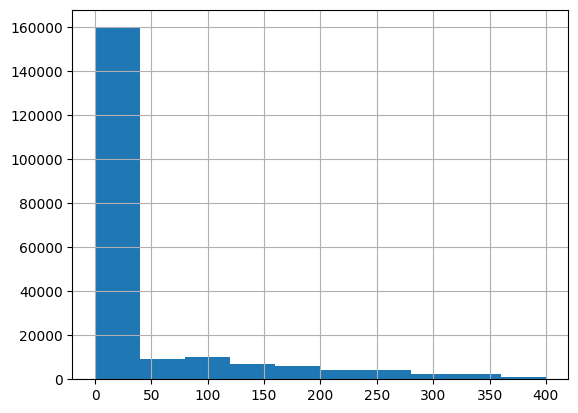

In [21]:
df["class_number"].hist()

In [22]:
len(df)

206201

In [23]:
df['split'].value_counts()

split
train    180286
val       25915
Name: count, dtype: int64

In [24]:
balanced_df = balance_classes(df)

<Axes: >

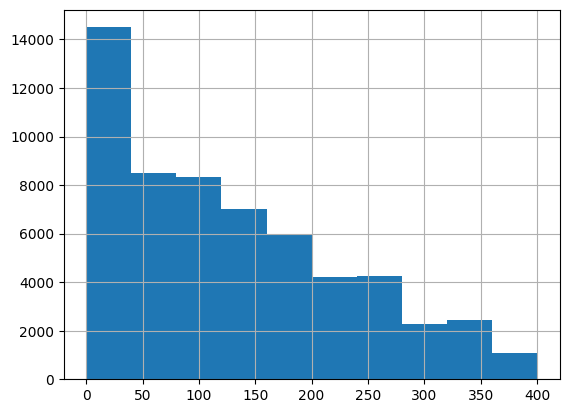

In [25]:
balanced_df["class_number"].hist()

In [26]:
balanced_df["class_number"].value_counts()

class_number
0      642
7      642
22     642
28     642
6      642
      ... 
377      8
337      7
392      6
389      5
383      3
Name: count, Length: 401, dtype: int64

In [27]:
len(balanced_df)

58543

In [28]:
balanced_df['split'].value_counts()

split
train    51216
val       7327
Name: count, dtype: int64

In [29]:
balanced_df.head()

,ID,original_id,class,xmin,ymin,xmax,ymax,split,class_number
0,SQ30xp68ZPvik0JEhPfIsQ_1,SQ30xp68ZPvik0JEhPfIsQ,other-sign,2201,1948,2321,2008,train,0
1,TuK3LUx1qHt6H2RtVUn0Rw_4,TuK3LUx1qHt6H2RtVUn0Rw,other-sign,963,2037,1144,2092,train,0
2,R7JJN86rO2pxlNqb-byEPA_2,R7JJN86rO2pxlNqb-byEPA,other-sign,2431,1387,2483,1475,train,0
3,lxOCMPkFMYpKUeRTtk-S2Q_3,lxOCMPkFMYpKUeRTtk-S2Q,other-sign,994,1152,1059,1172,train,0
4,PzY07Q4b_gqbu7KLpiNPhg_3,PzY07Q4b_gqbu7KLpiNPhg,other-sign,1586,1991,1610,2006,train,0


In [ ]:
augmented_df = perform_augmentation(balanced_df, input_dir)

<Axes: >

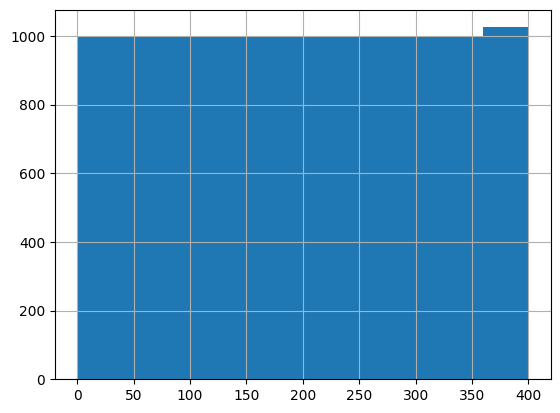

In [54]:
augmented_df["class_number"].hist()

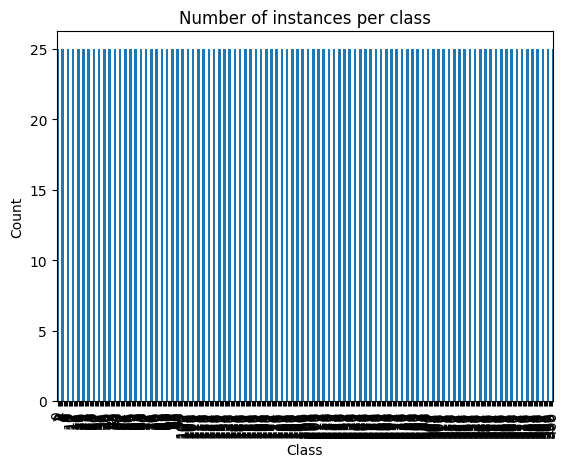

In [55]:
plot_sorted_counts(augmented_df, 'class_number')

In [56]:
len(augmented_df)

10025

In [57]:
augmented_df['split'].value_counts()

split
train    8786
val      1239
Name: count, dtype: int64

In [58]:
def check_files_exist(final_df, input_dir):
    """
    Check if the image file exists for each row in the DataFrame based on the 'ID' column.
    If 'augmented_image' is False, use 'original_id' instead of 'ID' to check the existence of the file.
    
    Parameters:
    - final_df: The DataFrame containing the 'ID' and 'original_id' columns, and a boolean 'augmented_image' column.
    - input_dir: The directory where the images are stored.
    
    Returns:
    - A Series with boolean values indicating whether the file exists for each row.
    """
    # Define the path to the images directory
    images_dir = Path(input_dir) / "images"
    
    # Check if each file exists, using 'original_id' if 'augmented_image' is False
    file_exists = final_df.apply(
        lambda row: (images_dir / f"{row['original_id']}.jpg").exists() if not row['augmented_image'] else (images_dir / f"{row['ID']}.jpg").exists(),
        axis=1
    )
    
    return file_exists

In [59]:
file_existence = check_files_exist(augmented_df, input_dir)

existing_files_df = augmented_df.copy()

# You can then add this information as a new column to the DataFrame if desired
existing_files_df['File Exists'] = file_existence

# Optionally, filter the DataFrame to get only the rows where the file exists
existing_files_df = existing_files_df[existing_files_df['File Exists'] == False]

In [60]:
existing_files_df

,ID,original_id,class,xmin,ymin,xmax,ymax,split,class_number,augmented_image,File Exists


### We can see that dataset is missing some parts. The test data as probably is not fully annotated thus we need to reshuffle manually

In [61]:
grouped_df = df.groupby("original_id").size().reset_index(name='count').sample(frac=1).reset_index(drop=True)

In [62]:
grouped_df

,original_id,count
0,aXSM3yNqvvKircrSWG40tw,2
1,po1wfjik9xNVRBWyevPXYQ,1
2,Q484_2jXytfIfa19u83DpA,3
3,XQluS2oE6iGRwk8pjK6zVQ,1
4,gsaO48CVVb5qolBGr9OAMQ,2
...,...,...
41731,EDKEgatAh8bIbFefDW76wg,2
41732,AQAA6GdOE6uEnolZhmjC0g,3
41733,yfX4xB1A0XaAfDzkKTTjrw,4
41734,gpuxLg5a_vnkUmNfvd4JSg,3


In [63]:
final_df = split_dataframe(augmented_df)

0 to 7517 is train_size
7518 to 8519 is val_size
8520 to 10024 is test_size


In [64]:
final_df['split'].value_counts()

split
train    7518
test     1505
val      1002
Name: count, dtype: int64

In [ ]:
create_yolo_structure(final_df, grouped_df, input_dir, class_to_number)